In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

In [14]:
data_show = pd.read_csv('data_preprocessing/general_nation_month_year.csv', index_col=0)
print(data_show.shape)
data_show.head()

(116, 3)


,Thang,So_Diem_Chay,Nam
0,1,386,2011
1,2,1967,2011
2,3,1292,2011
3,4,2099,2011
4,5,960,2011


In [9]:
def splitData(df, group):
    df = df[['Nam', 'Thang', 'So_Diem_Chay']]
    df = df.assign(
        Date = df[['Nam', 'Thang']].T.apply(lambda x: date(int(x.Nam), int(x.Thang), 1))
    )[[
        'Date', 'So_Diem_Chay'
    ]].set_index('Date')
    return df
# --------------
df_group_0 = splitData(data_show, 0)
df_group_0 = df_group_0.groupby(df_group_0.index).sum()
print(df_group_0.shape)
df_group_0.head(5)

(116, 1)


,So_Diem_Chay
Date,
2011-01-01,386
2011-02-01,1967
2011-03-01,1292
2011-04-01,2099
2011-05-01,960


In [43]:
train_0, test_0 = df_group_0.iloc[:104, 0], df_group_0.iloc[104:, 0]

In [75]:
# model = ExponentialSmoothing(train_0, seasonal='mul', seasonal_periods=12).fit()

def createModel(df, seasonal):
    arima = auto_arima(
        df,
        m=12,
        start_p=1,
        start_q=1,
        start_P=0,
        max_p=3,
        max_q=3,
        d=1,
        D=1,
        trace=True,
        seasonal=seasonal,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print('AIC Model :', arima.aic())
    return arima.fit(df)

model = createModel(df_group_0, True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2353.916, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2371.552, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2368.931, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2355.491, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2351.910, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2352.785, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2350.509, Time=0.58 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2334.891, Time=0.93 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=2332.959, Time=0.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2332.393, Time=0.34 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2352.583, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2334.273, Time=0.65 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2351.306, Time=0.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,2)(2,1,0)[12]

In [76]:
"""
predict = model.predict(
    start=test_0.index[0],
    end=test_0.index[-1]
)
predict
"""

predict = model.predict(n_periods=len(test_0))
predict

array([-4563.5586694 , -1347.45366406,  1122.69536872,  3106.29201666,
        7616.07374346, 39222.82640681, -1253.7626717 ,  3691.42343538,
        8867.70138396,  3370.20068146,  2316.39258052,  2054.68610275])

In [77]:
test_0

Date
2019-09-01     2298
2019-10-01     3920
2019-11-01     1677
2019-12-01     1241
2020-01-01     7188
2020-02-01    36146
2020-03-01     4637
2020-04-01     2689
2020-05-01     7658
2020-06-01     1733
2020-07-01       59
2020-08-01      314
Name: So_Diem_Chay, dtype: int64

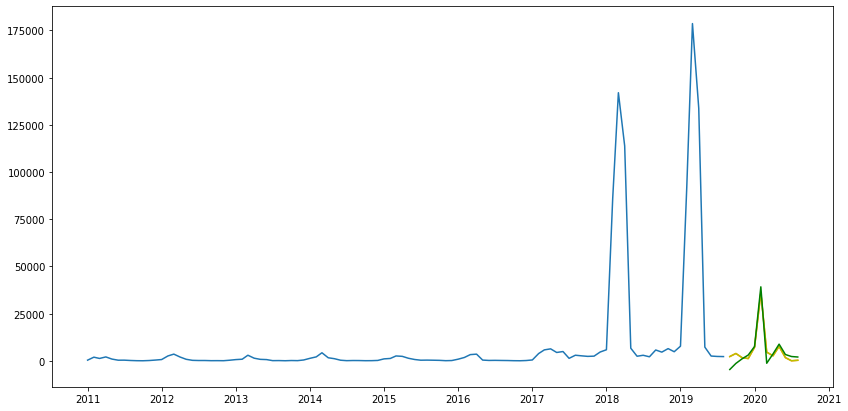

In [78]:
plt.figure(figsize=(14,7))
plt.plot(train_0.index, train_0)
plt.plot(test_0.index, test_0)
plt.plot(test_0.index, test_0, color='y')
plt.plot(test_0.index, predict, color='g')
plt.show()
plt.close()